In [1]:
import os
os.chdir("../")

In [2]:
import warnings
import numpy as np
import jax.numpy as jnp
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
import matplotlib.font_manager
font_path = "/home/nanxi/.local/share/fonts/Palatino-Linotype-Regular.ttf"
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    prop = matplotlib.font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Set font to {prop.get_name()}")

Set font to Palatino Linotype


In [3]:
from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="numpy", key=0, spectrum_type="kaimal-nd")
simulator.update_parameters(
    U_d=10.0,
    H_bar=20.0,
    alpha_0=0.30,
    z_0=0.01,
    w_up=5.0,
)
simulator.params

{'K': 0.4,
 'H_bar': 20.0,
 'z_0': 0.01,
 'alpha_0': 0.3,
 'C_x': 16.0,
 'C_y': 6.0,
 'C_z': 10.0,
 'w_up': 5.0,
 'N': 3000,
 'z_max': 450.0,
 'U_d': 10.0,
 'M': 6000,
 'T': 600.0,
 'dt': 0.1,
 'dw': 0.0016666666666666668,
 'z_d': 19.975,
 'backend': 'numpy'}

In [4]:
# xs = np.linspace(0, 10, 5)
# ys = np.linspace(0, 10, 5)
zs = np.linspace(80, 200, 121)
ys = np.zeros_like(zs)
xs = np.zeros_like(zs)
# positions = np.array(jnp.meshgrid(xs, ys, zs)).T.reshape(-1, 3)
positions = np.array(jnp.stack([xs, ys, zs], axis=1))
# order these positions by norm
positions = positions[np.linalg.norm(positions, axis=1).argsort()]
wind_speeds = simulator.spectrum.calculate_mean_wind_speed(positions[:, 2], 
                                                          simulator.params["U_d"], 
                                                          simulator.params["alpha_0"])

In [5]:
samples, frequencies = simulator.simulate_wind(positions, wind_speeds, component="u",)
samples.shape

(121, 6000)

In [6]:
# simulated_mean_wind_speed = np.mean(samples, axis=1)
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.scatter(positions[:, 2], wind_speeds, 
#            label="Theoretical Mean Wind Speed", color='C0', marker='o', s=80)

In [7]:
frequencies_theory = simulator.calculate_simulation_frequency(
    simulator.params["N"], simulator.params["dw"]
)
u_stars = simulator.spectrum.calculate_friction_velocity(
    positions[:, 2], simulator.params["U_d"], simulator.params["z_0"], simulator.params["z_d"],
    simulator.params["K"], simulator.params["alpha_0"]
)

S_theory = np.zeros((len(frequencies_theory), len(positions)), dtype=np.float32)
for freq_idx, freq in enumerate(frequencies_theory):
    S_theory[freq_idx, :] = simulator.spectrum.calculate_power_spectrum(
        freq, positions[:, 2], "u"
    )

In [8]:
np.mean(samples, axis=1)

array([-0.33716922, -0.31932727, -0.319635  , -0.33455092, -0.34862778,
       -0.36810855, -0.37846404, -0.41188946, -0.4323235 , -0.43309213,
       -0.44833321, -0.42196261, -0.44736245, -0.41427357, -0.42665856,
       -0.40059872, -0.43672236, -0.4202224 , -0.41451054, -0.4251148 ,
       -0.41005065, -0.41293376, -0.44356393, -0.42430784, -0.40377069,
       -0.41858462, -0.41915721, -0.43299147, -0.46456376, -0.46410716,
       -0.47626805, -0.47924822, -0.48384259, -0.49480421, -0.46550255,
       -0.50047108, -0.47516157, -0.44308271, -0.42915823, -0.41258867,
       -0.40531753, -0.38074905, -0.40910802, -0.40130888, -0.42389995,
       -0.43653825, -0.42190028, -0.43927319, -0.4581056 , -0.47286451,
       -0.46567458, -0.42742669, -0.47653578, -0.50159117, -0.50568471,
       -0.50522164, -0.5066287 , -0.54117334, -0.53248349, -0.49369818,
       -0.52286729, -0.51354394, -0.50638858, -0.53829459, -0.54565985,
       -0.57019476, -0.53350083, -0.54040665, -0.52105924, -0.50

Text(0.5, 0, 'Wind speed (m/s)')

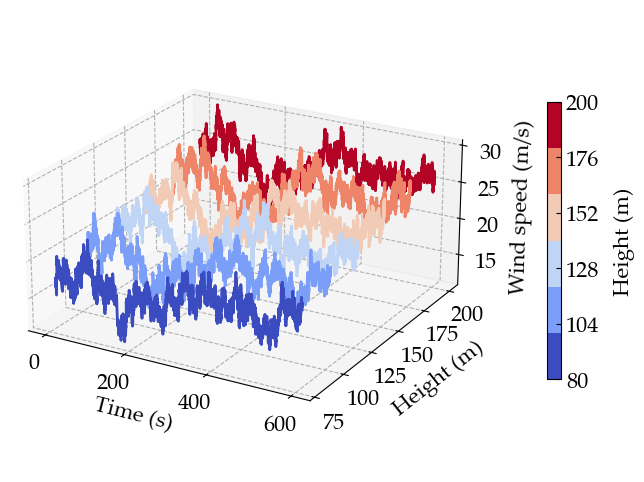

In [14]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'},)
fig.set_constrained_layout(True)
indices = np.arange(0, len(positions)+1, len(positions) // 5)
times = np.arange(0, simulator.params["M"] * simulator.params["dt"], simulator.params["dt"])

cmap = plt.get_cmap("coolwarm", len(indices))
for i, idx in enumerate(indices):

    uz = wind_speeds[indices[i]]
    data = samples[indices[i]] + uz
    z = positions[indices[i], 2]
    z = np.full_like(times, z)
    ax.plot(times, z, data, color=cmap((i)/(len(indices)-1)), 
            label=f"z={z[0]:.1f}m", lw=2, zorder=len(indices)-i)


ax_colorbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, pad=0.1, fraction=0.03)
ax_colorbar.set_label("Height (m)", labelpad=10)
# set value of the colorbar ticks
ax_colorbar.set_ticks([(i)/(len(indices)-1) for i in range(len(indices))])
ax_colorbar.set_ticklabels([f"{positions[idx, 2]:.0f}" for idx in indices])
#


ax.set_box_aspect([2,2,1])
ax.view_init(elev=22, azim=300)
ax.set_xlabel("Time (s)", labelpad=10)
ax.set_ylabel("Height (m)", labelpad=10)
ax.set_zlabel("Wind speed (m/s)", labelpad=5)
# 获取当前3D坐标区的位置 [left, bottom, width, height]
# fig.savefig("./img/validate_wind_timehistory_3d.png", dpi=300, bbox_inches='tight')
# fig.savefig("./img/validate_wind_timehistory_3d.pdf", bbox_inches='tight')
# fig.savefig("../wind_simulation_paper/validate_wind_timehistory_3d.pdf", bbox_inches='tight')

In [10]:
from statsmodels.tsa.stattools import adfuller
p_value_list = []
for idx, data in enumerate(samples):
    adf_result = adfuller(data)
    p_value = adf_result[1]
    p_value_list.append(p_value)
p_value_list = np.array(p_value_list)


In [11]:
print("Number of non-stationary series (p-value > 0.05):", np.sum(p_value_list > 0.05))
print("Max p-value:", np.max(p_value_list))

Number of non-stationary series (p-value > 0.05): 0
Max p-value: 0.0033365990998343253


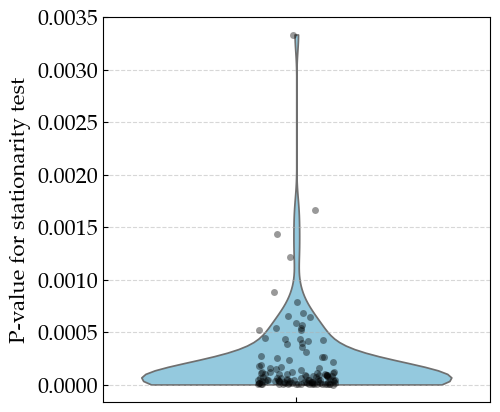

In [12]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
# sns.set_theme(style="whitegrid")
sns.violinplot(y=p_value_list, inner=None, color="skyblue", cut=0, ax=ax)
sns.stripplot(y=p_value_list, color="black", alpha=0.4, jitter=0.1, ax=ax)

ax.set(xlabel="", ylabel="P-value for stationarity test")
fig.savefig("./img/validate_wind_stationarity.png", dpi=300, bbox_inches='tight')
fig.savefig("./img/validate_wind_stationarity.pdf", bbox_inches='tight')
fig.savefig("../wind_simulation_paper/validate_wind_stationarity.pdf", bbox_inches='tight')

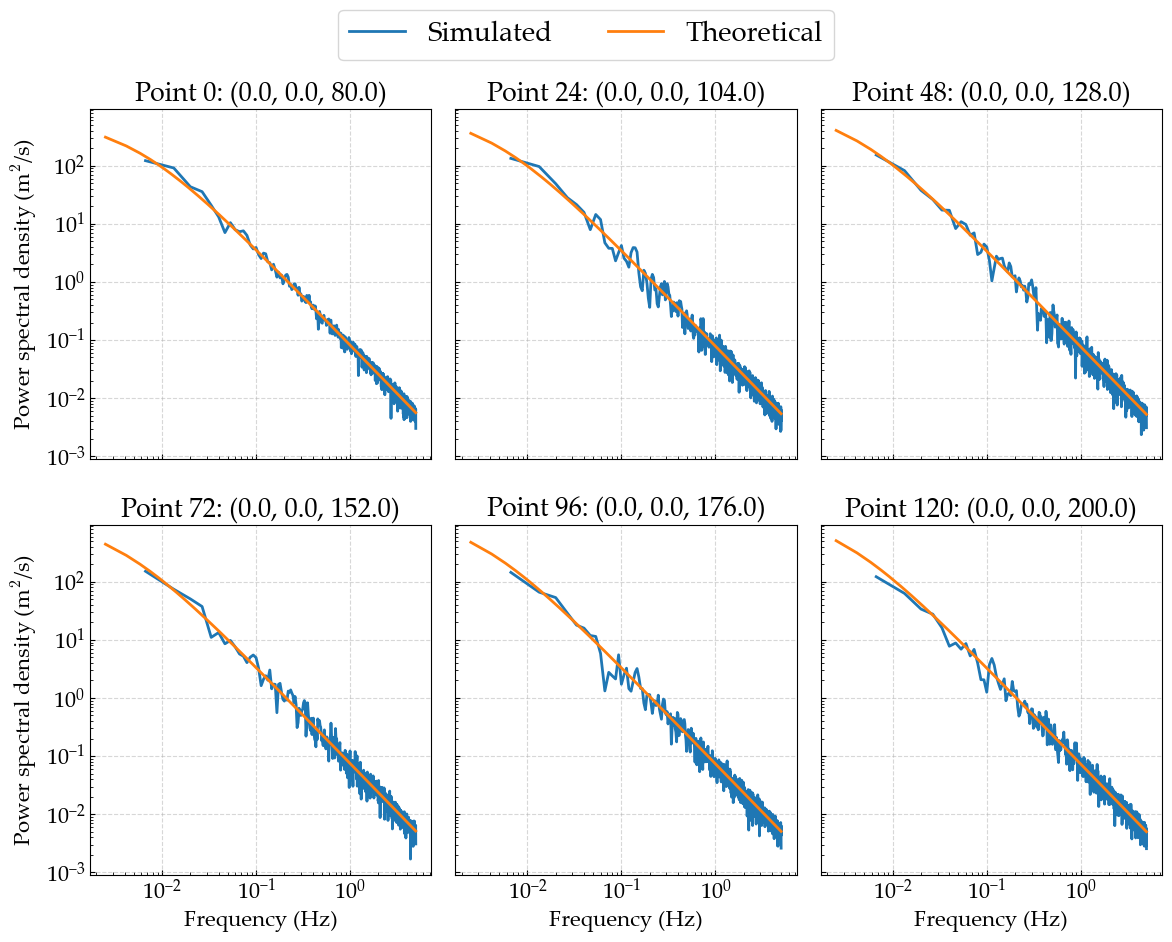

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True)
axes = axes.flatten()
indices = np.arange(0, len(positions)+1, len(positions) // 5)
for i, idx in enumerate(indices):
    ax = axes[i]
    data = samples[indices[i]]
    frequencies, psd = signal.welch(
        data,
        fs = 1.0 / simulator.params["dt"],
        nperseg=1500,
        window='hann',
        scaling='density',
    )
    ax.loglog(frequencies[1:], 
              psd[1:], label="Simulated", 
              color="C0", lw=2, )
    ax.loglog(
        frequencies_theory[1:],
        S_theory[1:, indices[i]],
        label="Theoretical",
        color="C1",
        lw=2
    )
    x, y, z = positions[indices[i]]
    ax.set_title(f"Point {idx}: ({x:.1f}, {y:.1f}, {z:.1f})")
    if i % 3 == 0:
        ax.set_ylabel("Power spectral density (m$^2$/s)")
    if i >= 3:
        ax.set_xlabel("Frequency (Hz)")

# customize legend
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=20)
fig.tight_layout()
fig.savefig("./img/validate_psd.png", dpi=300, bbox_inches='tight')
fig.savefig("./img/validate_psd.pdf", bbox_inches='tight')
fig.savefig("../wind_simulation_paper/validate_psd.pdf", bbox_inches='tight')


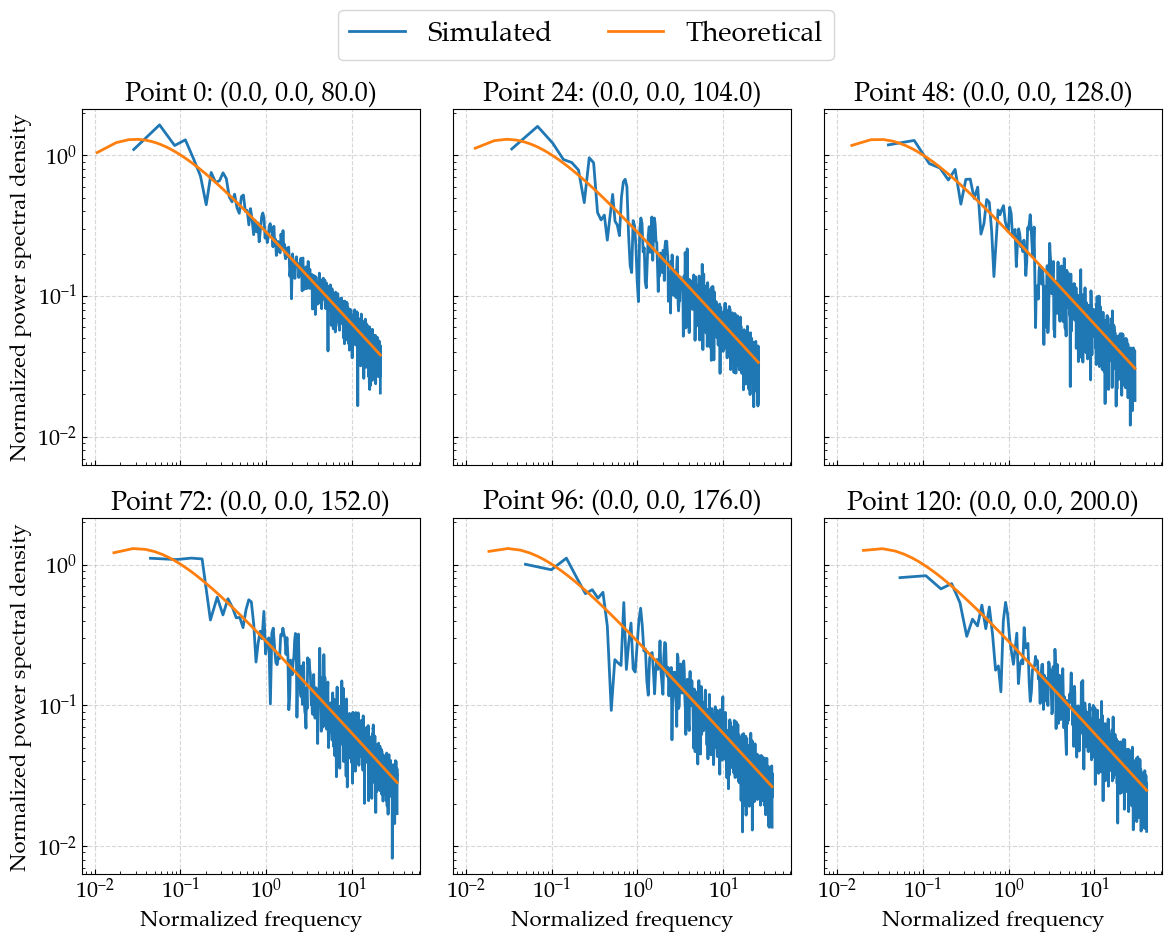

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True)
axes = axes.flatten()
indices = np.arange(0, len(positions)+1, len(positions) // 5)
for i, idx in enumerate(indices):
    ax = axes[i]
    data = samples[indices[i]]
    frequencies, psd = signal.welch(
        data,
        fs = 1.0 / simulator.params["dt"],
        nperseg=1500,
        window='hann',
        scaling='density',
    )
    u_star = u_stars[indices[i]]
    z = positions[indices[i], 2]
    uz = wind_speeds[indices[i]]
    ax.loglog(frequencies[1:] * z / uz, 
              psd[1:] * frequencies[1:] / u_star**2, label="Simulated", 
              color="C0", lw=2)
    ax.loglog(
        frequencies_theory[1:] * z / uz,
        S_theory[1:, indices[i]] * frequencies_theory[1:] / u_star**2,
        label="Theoretical",
        color="C1",
        lw=2
    )
    x, y, z = positions[indices[i]]
    ax.set_title(f"Point {idx}: ({x:.1f}, {y:.1f}, {z:.1f})")
    if i % 3 == 0:
        # ax.set_ylabel("Power Spectral Density (m$^2$/s)")
        ax.set_ylabel("Normalized power spectral density")
    if i >= 3:
        ax.set_xlabel("Normalized frequency")

# customize legend
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=20)
fig.tight_layout()
fig.savefig("./img/validate_psd_norm.png", dpi=300, bbox_inches='tight')
fig.savefig("./img/validate_psd_norm.pdf", bbox_inches='tight')
fig.savefig("../wind_simulation_paper/validate_psd_norm.pdf", bbox_inches='tight')


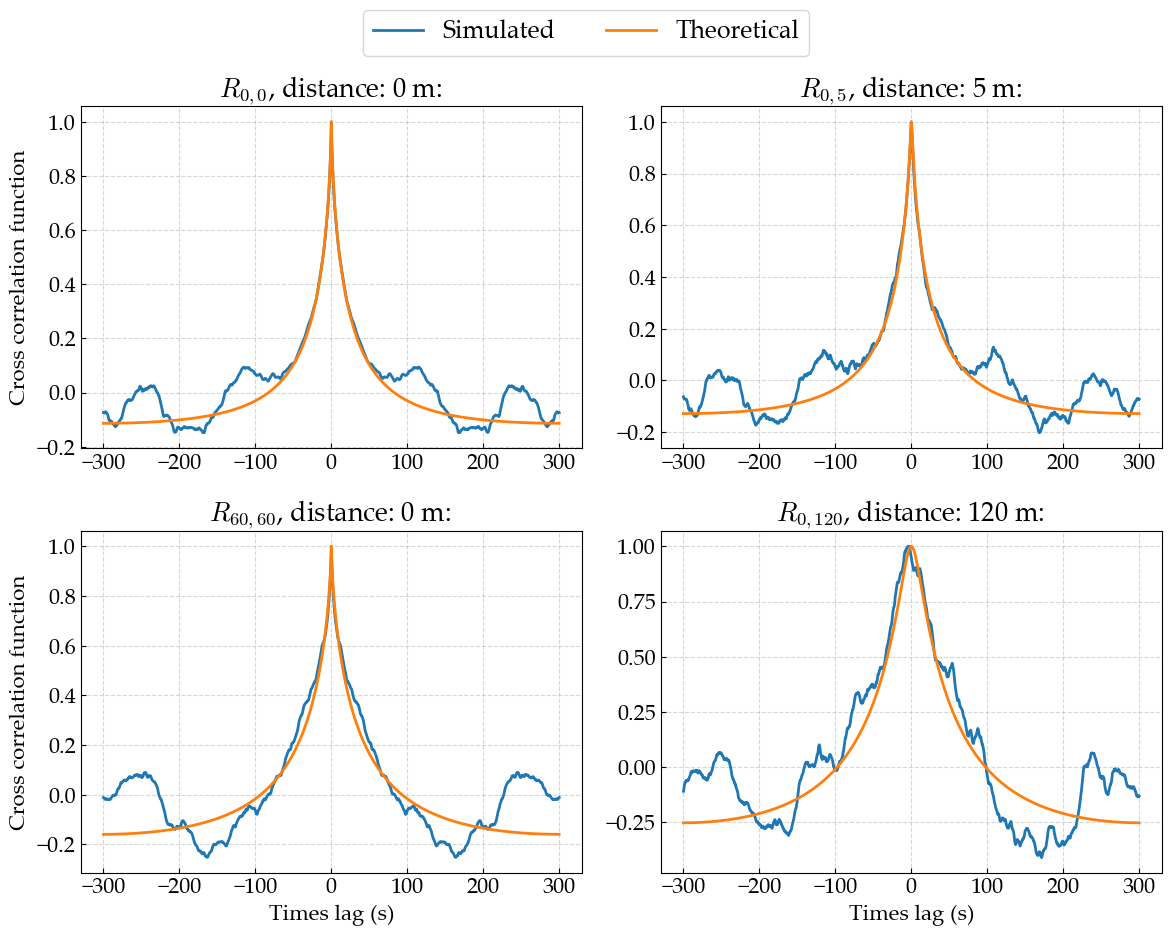

In [15]:
pairs = [(0, 0), (0, 5), (60, 60), (0, 120)]
visualizer = get_visualizer(backend="numpy", key=42, simulator=simulator)
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()
for i, pair in enumerate(pairs):
    ax = axes[i]
    idx1, idx2 = pair
    dist = np.linalg.norm(positions[idx1] - positions[idx2])

    plot_lag_times, plot_corr, theo_plot_times, theo_plot = \
        visualizer.plot_cross_correlation(
            samples,
            positions,
            wind_speeds,
            show=False,
            component="u",
            indices=pair,
            return_data=True
        )
    
    ax.plot(plot_lag_times, plot_corr
            , label="Simulated", color="C0", lw=2)
    ax.plot(theo_plot_times, theo_plot
            , label="Theoretical", color="C1", lw=2)
    x1, y1, z1 = positions[idx1]
    x2, y2, z2 = positions[idx2]
    ax.set_title(rf"$R_{{{idx1}, {idx2}}}$" + f", distance: {dist:.0f} m: ")
    if i % 2 == 0:
        ax.set_ylabel("Cross correlation function")
    if i >= 2:
        ax.set_xlabel("Times lag (s)")
    ax.xaxis.set_major_locator(plt.MultipleLocator(100))
# customize legend
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=18)
fig.tight_layout()
fig.savefig("./img/validate_correlation.png", dpi=300, bbox_inches='tight')
fig.savefig("./img/validate_correlation.pdf", bbox_inches='tight')
fig.savefig("../wind_simulation_paper/validate_correlation.pdf", bbox_inches='tight')

In [16]:
def compute_coherence(x, y, fs, nperseg=1000):
    """Compute the coherence between two signals."""
    frequencies, Cxy = signal.coherence(
        x, y,
        fs=fs,
        nperseg=nperseg,
        window='hamming',
    )
    return frequencies, Cxy


pair = (0, 1, 2,)
x_i, x_j = positions[pair, 0:1], positions[pair, 0:1].T  # (n, 1), (1, n)
y_i, y_j = positions[pair, 1:2], positions[pair, 1:2].T  # (n, 1), (1, n)
z_i, z_j = positions[pair, 2:3], positions[pair, 2:3].T  # (n, 1), (1, n)
U_i, U_j = wind_speeds[pair, None], wind_speeds[None, pair]  # (n, 1), (1, n)
frequencies = simulator.calculate_simulation_frequency(
    simulator.params["N"], simulator.params["dw"]
)


theoretical_coherence = np.array([
    simulator.calculate_coherence(
    x_i, x_j, y_i, y_j, z_i, z_j, freq_l, U_i, U_j,
    simulator.params["C_x"], simulator.params["C_y"], simulator.params["C_z"])
    for freq_l in frequencies
]) # (len(frequencies), n, n)

distances = np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2 + (z_i - z_j)**2)


In [17]:
# distances = distances.flatten()[::distances.shape[0]//10]
# theoretical_coherence = theoretical_coherence.reshape(-1, len(frequencies))[::theoretical_coherence.shape[1]//10]

# print("Distances shape:", distances.shape)
# print("Theoretical coherence shape:", theoretical_coherence.shape)
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.imshow(theoretical_coherence.T, aspect='auto',
#           extent=[distances.min(), distances.max(), frequencies.max(), frequencies.min()])
# ax.set_yscale('log')

0
1
2


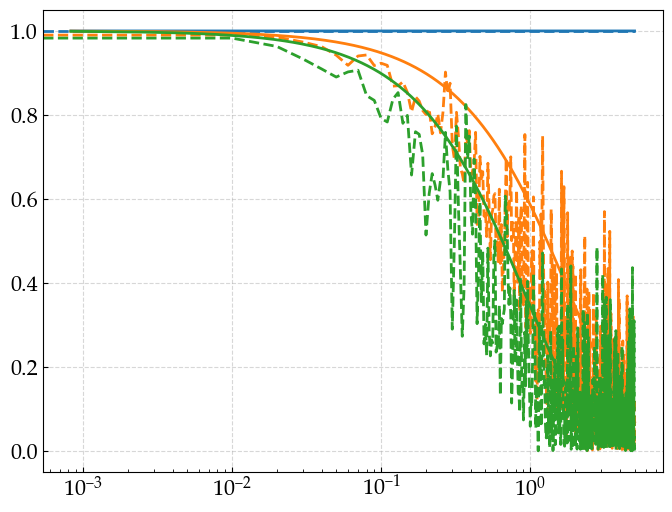

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
for idx, i in enumerate(pair):
    print(idx)
    ax.plot(frequencies, theoretical_coherence[:, idx, 0], label=f"Theoretical {idx}", lw=2, color=f"C{idx}")
    measured_frequencies, measured_coherence = compute_coherence(
        samples[pair[idx]], samples[pair[0]],
        fs=1.0 / simulator.params["dt"],
    )
    ax.plot(measured_frequencies, measured_coherence, label=f"Simulated {idx}", lw=2, ls='--', color=f"C{idx}")
ax.set_xscale('log')

In [19]:
theoretical_coherence[:, idx, 0].max()

np.float64(0.9991105593468974)